## Code 목차 


- [1. 분석환경 구축](#01)
    - [1.1  Colab 구글드라이브 연동](#01-01)
    - [1.2  라이브러리 임포트](#01-02)
- [2. 데이터 읽기](#02)
    - [2.1 데이터 통합](#02-01)
    - [2.2 데이터 설명](#02-02)  
- [3. 탐색적 데이터 분석](#03)

    - [3.1 타깃 변수 분포 확인하기](#03-01)
    - [3.2 센서 변수와 타깃 변수의 상관관계 파악](#03-02)
    - [3.3 범주형 변수에 따른 타깃 변수의 변화](#03-03)
    - [3.4 전체 공정 소요시간에 따른 타깃 변수의 변화](#03-04)
    - [3.5 센서의 집약된 통계량에 따른 타깃 변수의 변화](#03-05)

- [4. 데이터 전처리](#04)
    - [4.1 내부 데이터를 통한 변수 생성](#04-01)
    - [4.2 이상치 치환하기](#04-02)
    - [4.3 분산이 적은 변수 제거](#04-03)
    - [4.4 표준화](#04-04)
    - [4.5 원-핫 인코딩](#04-05)
    - [4.6 변수 선택](#04-06)

- [5. 모델링](#05)
    - [5.1 데이터 분할](#05-01)
    - [5.2 릿지 회귀 모델](#05-02)
    - [5.3 랜덤 포레스트 모델](#05-03)
    - [5.4 최종 모델 구축](#05-04)
    - [5.5 결과 해석](#05-05)
    - [5.6 예측 결과 파일 제출](#05-06)






<a name='01'></a>
## 1. 분석환경 구축 

<a name='01-01'></a>
### 1.1 Colab 구글 드라이브 연동 

<a name='01-02'></a>
### 1.2 라이브러리 임포트

In [1]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 읽기를 위한 라이브러리
import numpy as np

import pandas as pd
import scipy as sp
import statsmodels.api as sm
from datetime import datetime, date, timedelta
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 탐색적 데이터 분석을 위한 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, norm, probplot, boxcox
from itertools import product

# 모델링을 위한 라이브러리
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_regression, VarianceThreshold, RFECV
from catboost import CatBoostRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.outliers_influence import variance_inflation_factor


from bayes_opt import BayesianOptimization  # 자꾸 오류뜸ㄴ
import lightgbm as lgb
import xgboost

from pycaret.regression import * #까는거 오지게 빡셈 


<a name='02'></a>
## 2. 데이터 읽기

데이터 파일을 불러옵니다.

In [2]:
# 구글 드라이브 내 데이터가 위치한 경로를 설정합니다.
# path = "/content/drive/MyDrive/scv/"
path = "./data/"
# 학습용 데이터 
train_sensor = pd.read_csv(f'{path}train_sensor.csv')
train_quality = pd.read_csv(f'{path}train_quality.csv')

# 평가용 데이터 
predict_sensor = pd.read_csv(f'{path}predict_sensor.csv')

<a name='02-01'></a>
### 2.1 데이터 통합 

학습 데이터의 특징과 타깃 변수가 다른 파일에 존재하므로, 이를 통합하기 위한 작업을 수행합니다. 

key_val 을 기준으로 train_sensor (X인자)와 train_quality (y인자)의 데이터프레임을 통합합니다.

key_val 별 665개의 센서값 컬럼을 생성하기 위해 pandas의 pivot_table 함수를 사용합니다. 

pivot_table 의 주요 인자는 **index, agg_func, columns** 입니다.

1. **index** : key_val 을 기준으로 그룹핑을 하고자 하므로, index 에 key_val 과 그의 상위 그룹인 module_name 을 입력합니다.  
2. **agg_func** : values 에 mean_val 을 입력하고, 해당 값에 대한 산식을 sum으로 설정합니다. 
3. **columns** : step_param 을 columns 인자로 주어, key_val 별 665개의 스텝 단위의 센서 특징을 생성합니다. 

In [3]:
def make_dataset(X, y=None):
    
    # -----------------------------------
    # train_sensor (X 인자)
    # -----------------------------------
    df_X = X.copy()
    # step_id가 한자리일 경우 앞에 0으로 채움
    df_X['step_id'] = df_X['step_id'].apply(lambda x: str(x).zfill(2))
    # step_id 와 param_alias 를 결합한 임시 컬럼 step_param 을 생성합니다. ex. 17_EPD_para4
    df_X['step_param'] = df_X[['step_id', 'param_alias']].apply(lambda x: '_'.join(x), axis=1)
    print('feature 개수 : {}'.format(len(set(df_X['step_param']))))
    df_X_tmp = df_X.pivot_table(index = ['module_name','key_val'], columns = 'step_param', values='mean_val', aggfunc='sum')
    # 데이터 통합을 위해 인덱스를 key_val 로 재설정합니다. 
    df_X_tmp = df_X_tmp.reset_index(level=[0, 1])
    df_X_tmp.set_index('key_val', inplace=True)

    # -----------------------------------
    # 시간 데이터 
    # -----------------------------------
    df_X['end_time_tmp'] = df_X.apply(lambda x: x['step_id'] + '_end_time', axis=1)
    df_X['end_time'] = pd.to_datetime(df_X['end_time'])

    # end_time 은 센서 데이터가 서버에 도달한 시간으로 스텝 내 오차가 발생할 수 있습니다. 동일 스텝 구간내 공정 완료 시간이 다른 경우, max 함수를 사용하여 가장 최근에 
    # 수집된 시간을 가져옵니다. 
    df_time_tmp = df_X.pivot_table(index = ['key_val'], columns = 'end_time_tmp', values='end_time', aggfunc=lambda x : max(x.unique()))
    df_time_tmp = df_time_tmp.reset_index()
    df_time_tmp.set_index('key_val', inplace=True)

    # -----------------------------------
    # train_quality (y 인자)
    # -----------------------------------

    if y is None : # 평가용 데이터 
      
        col_target = []
        col_idx = ['module_name', 'key_val']
        df_complete = pd.concat([df_X_tmp, df_time_tmp], axis=1).reset_index()
        df_complete = df_complete.rename(columns={'index': 'key_val'})  
    
    else : # 학습용 데이터 
        df_y = y.copy()
        df_y.set_index('key_val', inplace=True)
      
        col_target = ['y']
        col_idx = ['module_name', 'key_val', 'end_dt_tm']
      
        # 센서 데이터, 시간데이터, 품질지표에 대하여 인덱스(key_val)기준으로 데이터프레임을 통합합니다.
        df_complete = pd.concat([df_X_tmp, df_time_tmp, df_y], axis=1).reset_index()
        df_complete = df_complete.rename(columns={'index': 'key_val'})
        # 컬럼 이름을 변경합니다.  
        df_complete.rename(columns={'msure_val':'y'}, inplace=True)

    # 컬럼 순서를 정렬합니다. 
    col_feats = df_X['step_param'].unique().tolist()
    col_feats.sort()
    col_time = [s for s in df_complete.columns.tolist() if "_end_time" in s]
    col_all = col_idx + col_target + col_feats + col_time
    df_complete = df_complete[col_all]
    
    # 컬럼을 소문자로 변경합니다. 
    df_complete.columns = df_complete.columns.str.lower()

    return df_complete


In [4]:
# 학습용 데이터 
train = make_dataset(train_sensor, train_quality)
# 평가용 데이터 
predict = make_dataset(predict_sensor)

feature 개수 : 665
feature 개수 : 665


<a name='02-02'></a>
### 2.2 데이터 설명

In [5]:
def describe_(df, pred=None): 
    
    obs = df.shape[0]
    types = df.dtypes # 자료형 
    counts = df.apply(lambda x: x.count()) # 값의 갯수 
    uniques = df.apply(lambda x: x.unique()) # 고유값 
    distincts = df.apply(lambda x: x.unique().shape[0]) # 고유값의 갯수 
    nulls = df.apply(lambda x: x.isnull().sum()) # 결측치의 갯수  
    nulls_ratio = (df.isnull().sum()/ obs) * 100 # 결측 비율 
    skewness = df.skew() # 왜도  
    kurtosis = df.kurt() # 첨도  
    
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'nulls_ratio', 'uniques', 'skewness', 'kurtosis']
        values_ = pd.concat([types, counts, distincts, nulls, nulls_ratio, uniques, skewness, kurtosis], axis = 1)

    else:
        corr = df.corr()[pred]
        values_ = pd.concat([types, counts, distincts, nulls, nulls_ratio, uniques, skewness, kurtosis, corr], axis = 1, sort=False)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'nulls_ratio', 'uniques', 'skewness', 'kurtosis', corr_col ]

    values_.columns = cols
    dtypes = values_.types.value_counts()
    print('___________________________\nData types:\n',values_.types.value_counts())
    print('___________________________')
    
    return values_

학습 데이터의 수는 611건이며, 665개의 센서 데이터와 7개의 시간 데이터의 특성을 가지고 있습니다. 

In [6]:
details = describe_(train, 'y')
display(details.sort_values(by='corr y', ascending=False))

Data shape: (611, 676)
___________________________
Data types:
 float64           666
datetime64[ns]      7
object              3
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,nulls_ratio,uniques,skewness,kurtosis,corr y
y,float64,611,591,0,0.0,"[1257.8492, 1253.30152, 1265.93544, 1248.5508,...",-0.059197,0.342927,1.000000
20_temp_para24,float64,611,575,0,0.0,"[50.28713, 51.87376, 49.72592, 51.89357, 49.61...",-0.438729,0.090808,0.196888
13_temp_para24,float64,611,189,0,0.0,"[69.5625, 72.6875, 68.3125, 71.125, 66.125, 72...",-0.309862,-0.110704,0.194742
12_temp_para24,float64,611,425,0,0.0,"[68.45, 70.56667, 67.43333, 70.66666, 66.55932...",-0.340203,-0.064225,0.189035
17_temp_para24,float64,611,419,0,0.0,"[69.63333, 72.21667, 69.96667, 71.73333, 69.35...",-0.439029,0.009083,0.183320
...,...,...,...,...,...,...,...,...,...
12_end_time,datetime64[ns],611,611,0,0.0,"[2021-10-18T11:16:38.000000000, 2021-10-04T11:...",NaN,NaN,NaN
13_end_time,datetime64[ns],611,611,0,0.0,"[2021-10-18T11:16:54.000000000, 2021-10-04T11:...",NaN,NaN,NaN
17_end_time,datetime64[ns],611,611,0,0.0,"[2021-10-18T11:24:51.000000000, 2021-10-04T11:...",NaN,NaN,NaN
18_end_time,datetime64[ns],611,611,0,0.0,"[2021-10-18T11:25:07.000000000, 2021-10-04T11:...",NaN,NaN,NaN


<a name='03'></a>
## 3. 탐색적 데이터 분석 

탐색적 데이터 분석을 통해 **데이터를 이해**하고, 모델에 유용한 **특징을 생성**할 수 있습니다. 

- 데이터에 대한 이해를 높이기 위해 타깃 변수의 분포 (3.1절) , 각 센서 변수와 타깃 변수와의 상관 관계 (3.2절)를 파악합니다. 

- 새로운 특징을 도출하기 위해 범주형 변수에 따른 타깃 변수의 변화 (3.3절) , 전체 공정 소요시간에 따른 타깃 변수의 변화 (3.4절) , 센서 변수의 집약된 통계량 (3.5절) 을 확인해봅니다.

In [7]:
# EDA를 위한 학습 데이터를 복사합니다.
df_eda = train.copy()

# 센서 컬럼과 날짜 컬럼을 정의합니다. 
col_sensor = df_eda.iloc[:, 4:-7].columns.tolist() 
col_time = df_eda.filter(regex='end').columns.tolist() 

assert len(col_sensor) == 665
assert len(col_time) == 8 

# 3.4절 공정 소요시간 분석에 필요한 변수를 정의합니다. 
lst_steps = ['04','06','12','13','17','18', '20']
lst_stepsgap = ['0406','0412','0413','0417','0418','0612','0613','0617','0618','0620',
                '1213','1217','1218','1220','1317','1318','1320','1718','1720','1820']

lst_sensors = []
for step in lst_steps:
    _ = [col for col in col_sensor if col[:2] == step]
    lst_sensors.append(_)

sensors_nm = list(map(lambda x: x[3:], lst_sensors[0]))

# 시간과 관련한 분석을 진행하기 위하여 날짜형으로 변환합니다. 
df_eda[col_time] = df_eda[col_time].apply(pd.to_datetime)

<a name='03-01'></a>
### 3.1 타깃 변수 분포 확인하기 

학습 데이터를 이용해 타깃 변수의 분포를 살펴보겠습니다. 

Seaborn 의 **distplot** 과 **probplot** 을 사용하여 타깃 변수의 분포 범위와 해당 값이 특정 구간에 치우쳐 있는지를 확인합니다.

In [8]:
def QQ_plot(data, measure):
    
    # 그래프의 크기를 지정합니다.
    fig = plt.figure(figsize=(10,4))
    
    # 1행 2열의 첫번째 히스토그램 그래프입니다.
    fig1 = fig.add_subplot(121)
    (mu, sigma) = norm.fit(data)
    # distplot 으로 타깃 변수의 분포를 확인합니다. kde = True를 입력하면 커널밀도추정 결과를 함께 표기할 수 있습니다.
    sns.distplot(data, kde=True, fit=norm)
    fig1.legend(['KDE', f'N({round(mu, 2)},{round(sigma**2, 2)})'], loc='upper right')
    fig1.set_title(f'{measure} Distribution', loc='center')
    fig1.set_xlabel(f'{measure}')

    # 1행 2열의 두번째 QQ Plot 그래프입니다.
    fig2 = fig.add_subplot(122)
    # 정규분포와 타깃변수의 분포를 비교합니다.
    res = probplot(data, plot=fig2)
    fig2.set_title(f'{measure} Probability Plot', loc='center')

    plt.tight_layout()
    plt.show()


타깃은 평균 1263.41, 분산 67.16 인 정규분포를 거의 따른다고 볼 수 있습니다.

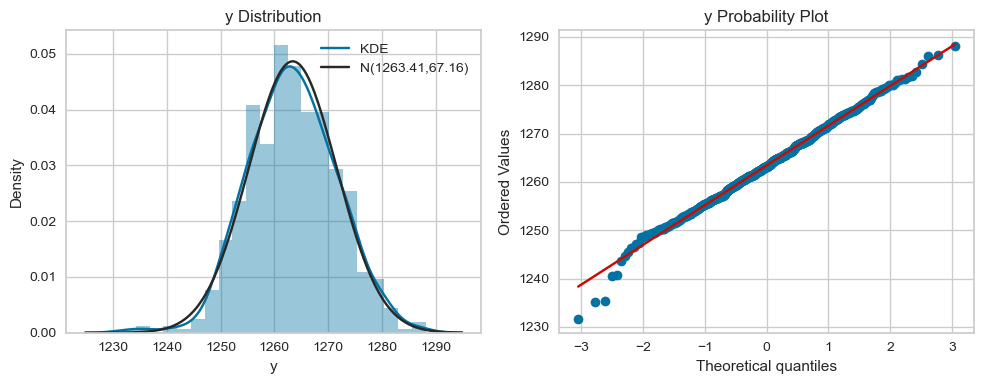

In [9]:
QQ_plot(df_eda['y'], 'y')

In [10]:
len(df_eda[df_eda['y'] < 1240])


3

<a name='03-02'></a>
### 3.2 센서 변수와 타깃 변수의 상관관계 파악
총 665개의 센서 변수와 타깃 변수 y 간의 관련성이 있는지 확인해보겠습니다. 

95개의 센서 변수는 총 7개의 공정 스텝 (4, 6, 12, 13, 17, 18, 20) 단위로 수집됩니다. 

In [11]:
def regplots(cols, data):
    
    # 각 센서별 7개의 스텝을 가지므로 행이 2개이고, 열이 4개인 서브 플롯을 생성합니다.
    fig, axes = plt.subplots(nrows=2, ncols=4, sharey=True, figsize=(15,8))
    
    # 서브 플롯 간의 세로 간격(hspace) 가로 간격(wspace)을 설정합니다. 
    fig.subplots_adjust(hspace=.4, wspace=.1)
    
    for i, ax in zip(range(len(cols)), axes.flat):

        sns.regplot(x=cols[i], y='y', data=data, ax=ax)
        ax.set_title(f'{cols[i].upper()}')
        ax.set_xlabel('')
        ax.set_ylabel('')
    
    # 8번째 서브 플롯은 필요 없으므로 표기하지 않습니다. 
    axes.flat[-1].set_visible(False)
    plt.tight_layout()
    plt.show()

수치형 변수 X 수치형 변수 조합 시각화에 유용한 산점도 그래프 scatter plot 를 작성합니다. 

**regplot** 을 사용하여 산점도와 함께 데이터의 경향성을 나타내는 추세선까지 함께 표시합니다.

*****['efem_para2']


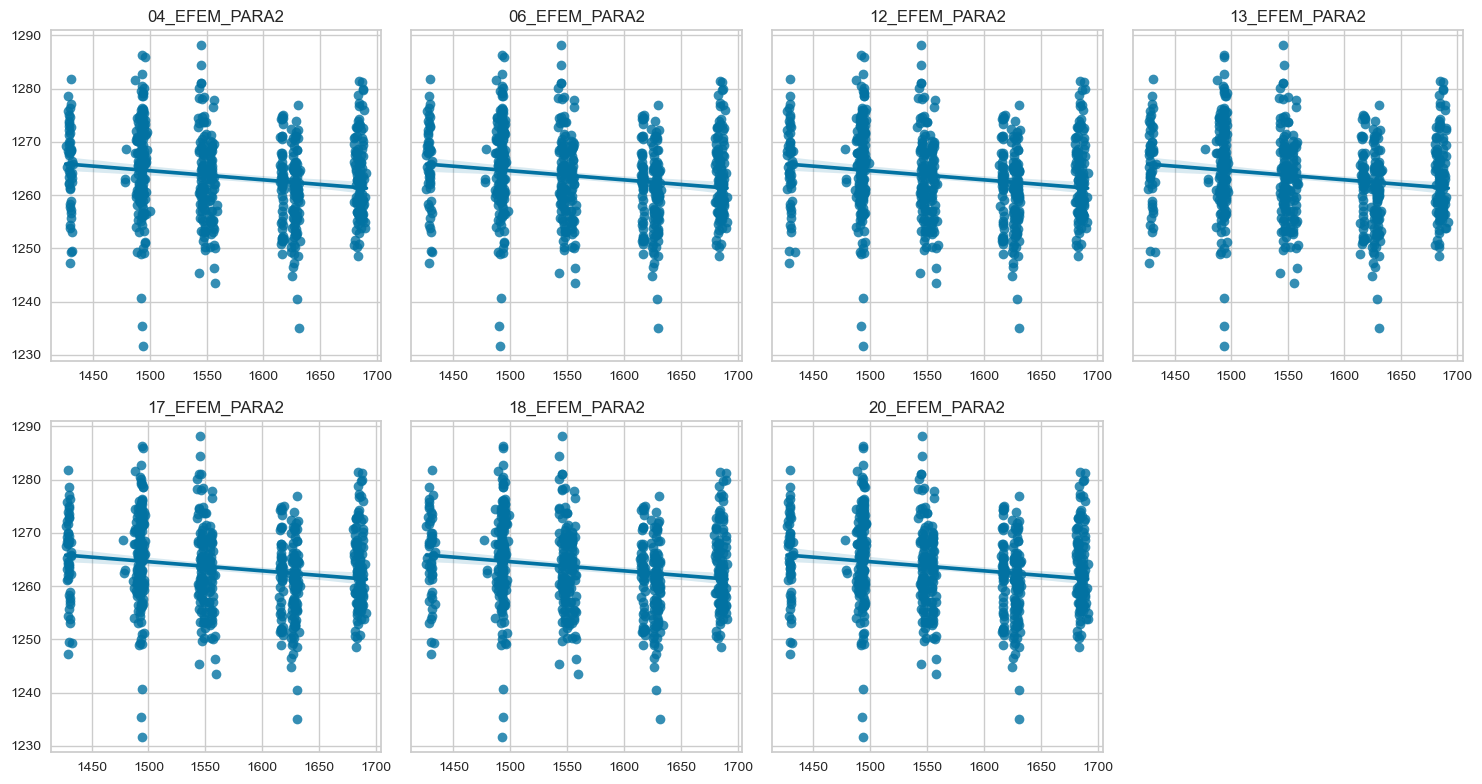

In [12]:
for ix, sensor_nm in enumerate(sensors_nm):
    print(f'*****{[sensor_nm]}')

    # tmp_lst 는 {스텝}_{센서명} 형식으로 센서의 총 7개의 스텝 컬럼 리스트를 생성합니다.
    # ex. 04_efem_para2, 06_efem_para2, ..., 20_efem_para2
    tmp_lst = list(map(lambda x: f'{x}_{sensor_nm}', lst_steps))
    regplots(tmp_lst, df_eda)
    
    # 총 95개의 센서를 시각화를 할 경우 아래 코드를 주석 처리 합니다.
    if ix == 0:
        break

<a name='03-03'></a>
### 3.3 범주형 변수에 따른 타깃 변수의 변화

총 모듈(module_name)의 고유값의 갯수는 47개입니다. 모듈 이름은 _ 를 기준으로 EQ와 PM 식별자로 조합되어 있습니다.

In [13]:
idx = 'module_name'
# 모듈의 고유값과 고유값의 갯수를 구합니다.
module_unq = df_eda[idx].unique()
module_nunq = df_eda[idx].nunique()

print(f'***')
print(f'No. of Module : {module_nunq}')
print(f'{module_unq}')

***
No. of Module : 47
['EQ10_PM1' 'EQ10_PM2' 'EQ10_PM5' 'EQ10_PM6' 'EQ11_PM1' 'EQ11_PM2'
 'EQ11_PM5' 'EQ11_PM6' 'EQ12_PM1' 'EQ12_PM2' 'EQ12_PM5' 'EQ12_PM6'
 'EQ1_PM1' 'EQ1_PM2' 'EQ1_PM5' 'EQ1_PM6' 'EQ2_PM1' 'EQ2_PM2' 'EQ2_PM5'
 'EQ2_PM6' 'EQ3_PM1' 'EQ3_PM2' 'EQ3_PM5' 'EQ3_PM6' 'EQ4_PM1' 'EQ4_PM2'
 'EQ4_PM5' 'EQ4_PM6' 'EQ5_PM1' 'EQ5_PM2' 'EQ5_PM5' 'EQ5_PM6' 'EQ6_PM1'
 'EQ6_PM2' 'EQ6_PM5' 'EQ6_PM6' 'EQ7_PM1' 'EQ7_PM2' 'EQ7_PM5' 'EQ7_PM6'
 'EQ8_PM1' 'EQ8_PM2' 'EQ8_PM5' 'EQ8_PM6' 'EQ9_PM1' 'EQ9_PM2' 'EQ9_PM5']


범주의 정도를 상위 레벨에서 보기 위하여 EQ를 기준으로 재범주화 해보겠습니다.

apply 를 사용하여 모듈 이름의 EQ 식별자 부분만 추출하여 module_name_eq 컬럼에 값을 저장합니다.

<AxesSubplot: xlabel='module_name_eq', ylabel='y'>

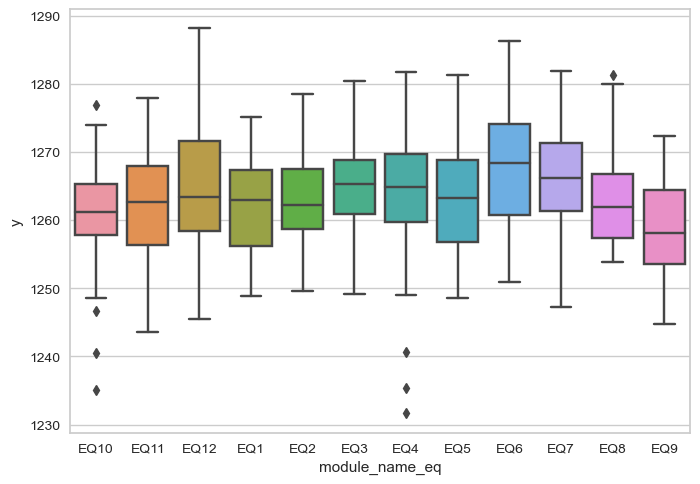

In [14]:
# 모듈 이름의 상위 집계단위를 나타내는 module_name_eq 범주형 변수를 생성하는 함수입니다.
def gen_cate_feats(df):
    df['module_name_eq'] = df['module_name'].apply(lambda x : x.split('_')[0])
    return df 
   
df_eda = gen_cate_feats(df_eda)
sns.boxplot(x='module_name_eq', y='y', data=df_eda)

<a name='03-04'></a>
### 3.4 전체 공정 소요시간에 따른 타깃 변수의 변화 

전체 및 개별 공정 소요시간 변수를 생성하는 함수를 작성합니다. 

전체 공정 소요시간은 마지막 공정 완료시간 ***20_end_time*** 과 첫번째 공정 완료시간 **04_end_time** 의 차이(초)를 계산한 값입니다.

In [15]:
# 전체 및 개별 공정 소요시간 변수를 생성하는 함수입니다.
def gen_duration_feats(df, lst_stepsgap):
    
    # 전체 공정 소요시간(초) 변수를 생성합니다. 
    df['gen_tmdiff'] = (df['20_end_time'] - df['04_end_time']).dt.total_seconds()
    
    # 개별 스텝간 공정 소요시간(초) 변수를 생성합니다. 
    # ex. gen_tmdiff_0406 : 04 스텝 공정 완료 시간과 06 스텝 공정 완료 시간의 차이 
    for stepgap in lst_stepsgap:
        df[f'gen_tmdiff_{stepgap}'] = (df[f'{stepgap[2:]}_end_time'] - df[f'{stepgap[:2]}_end_time']).dt.total_seconds()

    return df

df_eda = gen_duration_feats(df_eda, lst_stepsgap)

전체 공정 소요시간은 최소 30.6분에서 최대 31.9분입니다. 

개별 스텝간 공정 소요시간도 확인하였을 시, 6번째 스텝에서 12번째 스텝 간 소요시간이 가장 길었습니다. 

In [16]:
# 전체 공정 소요시간 및 개별 공정 소요시간 컬럼을 리스트 형태로 추출합니다. 
col_tmdiff = df_eda.filter(regex='gen_tmdiff($|_\d)').columns.tolist()

# 공정 소요시간의 통계값(최소, 최대, 평균)을 추출하는 함수입니다.
def tmdiff_stats(x):
    return [round(x.min()/60,1), round(x.max()/60,1), round(x.mean()/60,1)]

df_tmp = df_eda[col_tmdiff].apply(tmdiff_stats).T
df_tmp.columns = ['MIN', 'MAX', 'MEAN']
df_tmp

,MIN,MAX,MEAN
gen_tmdiff,30.6,31.9,31.5
gen_tmdiff_0406,1.9,2.5,2.3
gen_tmdiff_0412,15.2,16.6,16.2
gen_tmdiff_0413,15.5,16.9,16.5
gen_tmdiff_0417,23.4,24.8,24.4
gen_tmdiff_0418,23.7,25.1,24.7
gen_tmdiff_0612,13.3,14.2,13.9
gen_tmdiff_0613,13.5,14.4,14.2
gen_tmdiff_0617,21.5,22.4,22.1
gen_tmdiff_0618,21.7,22.7,22.4


전체 공정 소요시간은 30분대 공정이 완료된 장비와 31분대에 공정이 완료된 장비로 뚜렷이 구분됩니다. 

대부분의 장비는 31분대에 완료되었으며, 일찍 공정을 마친 장비는 주로 EQ7, EQ8 모듈입니다.


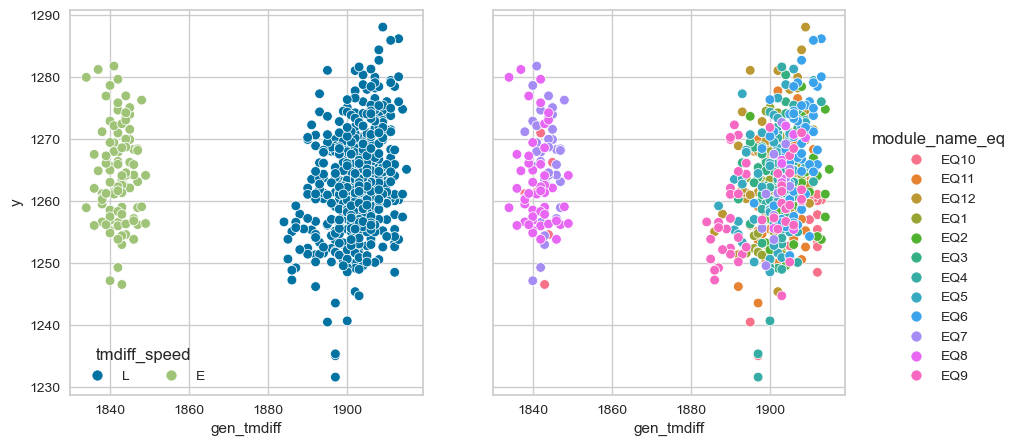

In [17]:
# 시각화를 위하여 1870초를 기준으로 일찍 마친 장비와 늦께 마친 장비를 구분합니다.
df_eda.loc[df_eda['gen_tmdiff'] < 1870, 'tmdiff_speed'] = 'E' # Early 
df_eda.loc[df_eda['gen_tmdiff'] > 1870, 'tmdiff_speed'] = 'L' # Late

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,5))
sns.scatterplot(x='gen_tmdiff', y='y', hue='tmdiff_speed', data = df_eda, ax=axes[0])
sns.scatterplot(x='gen_tmdiff', y='y', hue='module_name_eq', data = df_eda, ax=axes[1])
axes[0].legend(loc='lower left', ncol=2, title='tmdiff_speed')
axes[1].legend(loc='lower left', ncol=1, title='module_name_eq', bbox_to_anchor=(1.04, 0))

<a name='03-05'></a>
### 3.5 센서의 집약된 통계량에 따른 타깃 변수의 변화

센서 측정치에 대해 총 7개의 스텝을 집약한 표준편차를 확인해보겠습니다. 전 구간에서 센서 측정치의 흩어진 정도를 알 수 있습니다. 

In [18]:
# 센서의 집약된 표준편차 변수를 생성하는 함수입니다.
def gen_stats_feats(df, sensors_nm, lst_steps):
    
    for sensor_nm in sensors_nm:

        # 센서별 총 7개의 스텝 컬럼 리스트를 생성합니다.
        # ex. 04_efem_para2, 06_efem_para2, ..., 20_efem_para2
        tmp_lst = list(map(lambda x: f'{x}_{sensor_nm}', lst_steps))

        # 전 스텝을 집약하여 센서의 표준편차 변수를 생성합니다. 
        df[f'gen_{sensor_nm}_std'] = df[tmp_lst].std(axis=1)
        
    return df

df_eda = gen_stats_feats(df_eda, sensors_nm, lst_steps)

In [19]:
# 센서의 집약된 평균 변수를 생성하는 함수입니다.
def gen_avg_feats(df, sensors_nm, lst_steps):
    
    for sensor_nm in sensors_nm:

        # 센서별 총 7개의 스텝 컬럼 리스트를 생성합니다.
        # ex. 04_efem_para2, 06_efem_para2, ..., 20_efem_para2
        tmp_lst = list(map(lambda x: f'{x}_{sensor_nm}', lst_steps))

        # 전 스텝을 집약하여 센서의 표준편차 변수를 생성합니다. 
        df[f'gen_{sensor_nm}_mean'] = df[tmp_lst].mean(axis=1)
        
    return df

df_eda = gen_avg_feats(df_eda, sensors_nm, lst_steps)

<AxesSubplot: xlabel='gen_time_para5_std', ylabel='y'>

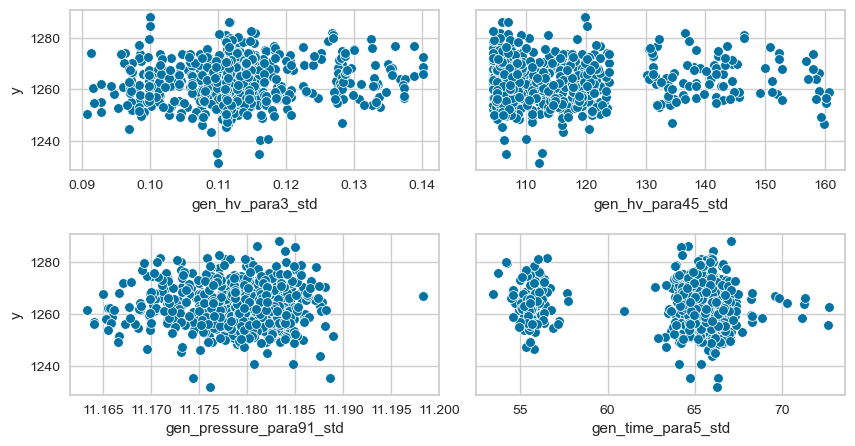

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(10,5))
fig.subplots_adjust(hspace=.4, wspace=.1)

sns.scatterplot(x='gen_hv_para3_std', y='y', data = df_eda, ax=axes[0,0], legend=False)
sns.scatterplot(x='gen_hv_para45_std', y='y', data = df_eda, ax=axes[0,1], legend=False)
sns.scatterplot(x='gen_pressure_para91_std', y='y',  data = df_eda, ax=axes[1,0], legend=False)
sns.scatterplot(x='gen_time_para5_std', y='y', data = df_eda, ax=axes[1,1], legend=False)


In [21]:
param_set = set(x.split('_')[0].lower() for x in train_sensor['param_alias'])

In [22]:
def gen_avg_param(df):

        for i in param_set: # 파라미터가 들어가 있는 컬럼들
                
                param = [x for x in df.columns if i in x and 'para' in x]

                df[f'gen_avg_{i}'] = df[param].mean(axis=1)

        return df

In [23]:
def gen_avg_param(df):

        for i in param_set: # 파라미터가 들어가 있는 컬럼들
                
                param = [x for x in df.columns if i in x and 'para' in x]

                df[f'gen_avg_{i}'] = df[param].mean(axis=1)

        return df

def gen_std_param(df):

        for i in param_set: # 파라미터가 들어가 있는 컬럼들
                
                param = [x for x in df.columns if i in x and 'para' in x]

                df[f'gen_std_{i}'] = df[param].std(axis=1)

        return df

In [24]:
def gen_avg_step(df):

    for i in lst_steps:

        param_steps = [x for x in df.columns if i == x.split('_')[0] and 'para' in x]

        df[f'gen_avg_{i}'] = df[param_steps].mean(axis=1)

    return df

In [25]:
def log_skew(df):
    
    numeric = [k for k in df.columns if df[k].dtype == 'float']
    numeric_lst = pd.DataFrame(abs(df[numeric].skew())).sort_values(by = 0, ascending = False)[:100].index.tolist()
    
    for col in numeric_lst:

        if df[col].skew() < 0:
            df[col] = df[col] **2
        else:
            df[col] = df[col] ** 1/2

    return df

In [26]:
def cut_data(df, col):

    bins = [1400, 1450, 1520, 1570, 1660, 1750]
    labels = ['a', 'b', 'c', 'd', 'e']

    cuts = pd.cut(df[col], bins, right = False, labels = labels)
    
    return cuts

def cut_epd_data(df, col):
    
    bins_epd4 = [0, 50, 100]
    labels = ['a','b']

    cuts_efem = pd.cut(df[col], bins_epd4, right = False, labels = labels)

    return cuts_efem

In [27]:
sp_product = list(product(lst_steps, param_set))

step_params = ['_'.join(sp_product[i]) for i in range(len(sp_product))]

In [28]:
def gen_std_stpa(df):

    for step_param in step_params:

        step_param_cols = [x for x in lst_sensors[0] if step_param in x]

        df[f'gen_{step_param}_std'] =  df[step_param_cols].std(axis=1)

    return df

def gen_avg_stpa(df):

    for step_param in step_params:

        step_param_cols = [x for x in lst_sensors[0] if step_param in x]

        df[f'gen_{step_param}_avg'] =  df[step_param_cols].std(axis=1)

    return df
        
df_eda = gen_std_stpa(df_eda)
df_eda = gen_avg_stpa(df_eda)

In [29]:
# EDA를 위한 데이터 프레임 제거합니다.
del df_eda

<a name='04'></a>
## 4. 데이터 전처리

탐색적 데이터 분석을 통해 도출한 추가 변수를 생성(4.1절)합니다. 

이상치 확인(4.2절), 분산이 적은 특징 제거(4.3절), 수치형 변수의 표준화(4.4절) 그리고 범주형 변수의 원-핫 인코딩(4.5절) 변환을 하여 데이터를 전처리합니다.

<a name='04-01'></a>
### 4.1 내부 데이터를 통한 변수 생성 



In [30]:
# 전처리를 위한 학습용 데이터와 평가용 데이터를 복사합니다.
df_prep_train = train.copy()
df_prep_predict = predict.copy()

탐색적 데이터 분석(3.3~3.5절)에서 분석한 결과를 활용해 새로운 특징을 생성합니다. 


*   모듈 이름의 상위 집계 단위를 나타내는 1개의 범주형 변수 (3.3절)
*   전체 및 개별 공정 소요시간을 나타내는 7개의 변수(3.4절)
*   센서 변수의 집약된 표준편차를 나타내는 95개의 변수 (3.5절)




In [31]:
# 모듈 이름의 상위 집계 단위를 나타내는 1개의 범주형 변수를 생성합니다(3.3절)
df_prep_train = gen_cate_feats(df_prep_train)
df_prep_predict = gen_cate_feats(df_prep_predict)

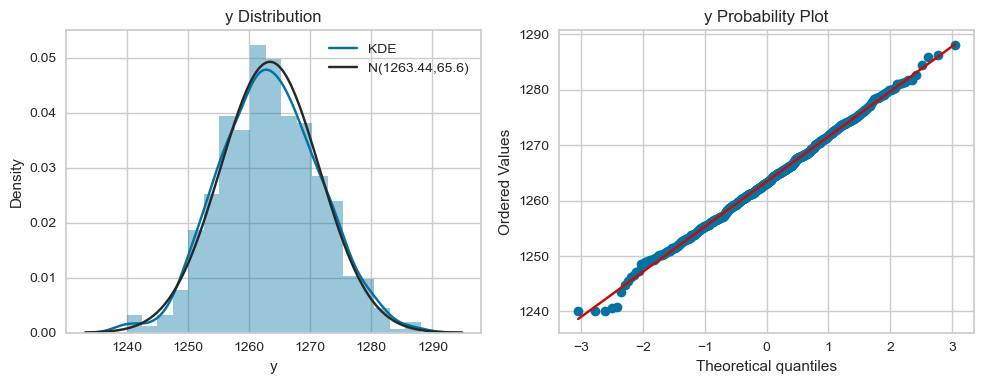

In [32]:
QQ_plot(df_prep_train['y'].clip(1240, 1500), 'y')

In [33]:
# y값 1240 이하 값 이상치 clip
df_prep_train['y']  = df_prep_train['y'].clip(1240, 1500)

In [34]:
# 전체 및 개별 공정 소요시간 7개의 변수를 생성합니다(3.4절)
df_prep_train = gen_duration_feats(df_prep_train, lst_stepsgap)
df_prep_predict = gen_duration_feats(df_prep_predict, lst_stepsgap)

In [35]:
# 센서 변수의 집약된 95개의 표준편차 변수를 생성합니다(3.5절)
df_prep_train = gen_stats_feats(df_prep_train, sensors_nm, lst_steps)
df_prep_predict = gen_stats_feats(df_prep_predict, sensors_nm, lst_steps)
df_prep_train.filter(regex='_std').head(2)

,gen_efem_para2_std,gen_efem_para25_std,gen_efem_para78_std,gen_epd_para4_std,gen_epd_para40_std,gen_epd_para63_std,gen_epd_para80_std,gen_esc_para84_std,gen_esc_para94_std,gen_fr_para28_std,gen_fr_para35_std,gen_fr_para61_std,gen_fr_para69_std,gen_gas_para10_std,gen_gas_para13_std,gen_gas_para15_std,gen_gas_para19_std,gen_gas_para21_std,gen_gas_para26_std,gen_gas_para27_std,gen_gas_para33_std,gen_gas_para36_std,gen_gas_para39_std,gen_gas_para46_std,gen_gas_para48_std,gen_gas_para50_std,gen_gas_para51_std,gen_gas_para52_std,gen_gas_para59_std,gen_gas_para6_std,gen_gas_para70_std,gen_gas_para71_std,gen_gas_para73_std,gen_gas_para74_std,gen_gas_para85_std,gen_he_para1_std,gen_he_para22_std,gen_he_para88_std,gen_he_para95_std,gen_hv_para3_std,gen_hv_para45_std,gen_hv_para47_std,gen_hv_para56_std,gen_position_para72_std,gen_power_para14_std,gen_power_para49_std,gen_power_para57_std,gen_power_para68_std,gen_power_para76_std,gen_power_para82_std,gen_pressure_para91_std,gen_temp_para11_std,gen_temp_para12_std,gen_temp_para17_std,gen_temp_para18_std,gen_temp_para20_std,gen_temp_para23_std,gen_temp_para24_std,gen_temp_para32_std,gen_temp_para38_std,gen_temp_para53_std,gen_temp_para54_std,gen_temp_para55_std,gen_temp_para58_std,gen_temp_para60_std,gen_temp_para65_std,gen_temp_para66_std,gen_temp_para79_std,gen_temp_para86_std,gen_temp_para87_std,gen_temp_para92_std,gen_temp_para93_std,gen_time_para16_std,gen_time_para29_std,gen_time_para30_std,gen_time_para34_std,gen_time_para37_std,gen_time_para41_std,gen_time_para42_std,gen_time_para43_std,gen_time_para44_std,gen_time_para5_std,gen_time_para62_std,gen_time_para64_std,gen_time_para67_std,gen_time_para7_std,gen_time_para75_std,gen_time_para77_std,gen_time_para8_std,gen_time_para81_std,gen_time_para83_std,gen_time_para89_std,gen_time_para9_std,gen_time_para90_std,gen_tmp_para31_std
0,1.540604,1.487185,0.045480,377.964435,0.382780,0.0,0.0,0.000000,0.0,2926.724319,0.0,0.0,0.0,0.0,63.881263,15.118579,0.0,0.999889,1.893326,17.497957,45.31794,1.109240,3.288291,54.206229,48.795004,37.770840,4.757350,3.469752,66.962550,0.616876,5.669467,45.702897,5.184647,22.256973,26.564031,2.43975,0.190650,0.354108,9.759001,0.101412,118.511328,104.662479,0.248868,4.578497,3382.332411,0.045814,1221.240587,0.0,232.065299,7072.106169,11.174723,0.002327,0.068593,0.084603,0.198410,7.118753,0.063101,23.35050,2.440712,9.894757,0.111677,21.915420,0.012505,0.0,12.995917,0.638476,0.016624,0.002412,2.063385,0.197356,0.026269,0.111677,0.163356,0.161660,0.163356,0.163356,0.163207,0.163207,0.163356,0.163356,0.163356,65.645047,0.163356,0.163207,0.163356,0.163207,0.163356,0.163356,0.163207,0.163356,0.163207,0.163356,0.163207,0.163356,0.54963
1,1.313742,1.372572,0.045224,377.964435,0.462813,0.0,0.0,0.003024,0.0,2926.724319,0.0,0.0,0.0,0.0,63.881263,15.118579,0.0,1.033772,1.906075,17.498882,45.31794,1.123304,2.229990,54.219319,48.795004,37.767439,4.812088,3.467659,66.958126,0.645101,5.669467,45.701801,5.186014,22.256973,26.555342,2.43975,0.191156,0.303350,9.759903,0.111274,108.138800,166.346825,0.227366,4.470249,3418.071186,0.386554,1221.240587,0.0,231.793164,7072.011338,11.183555,0.001923,0.002268,0.023258,0.181635,6.384966,0.069156,24.81661,2.443237,9.869061,0.158098,22.411362,0.004146,0.0,12.545318,0.615928,0.010626,0.001758,2.061726,0.214394,0.025726,0.158098,0.165981,0.161527,0.165981,0.165981,0.163207,0.163207,0.165981,0.165981,0.165981,66.214820,0.165981,0.163207,0.165981,0.163207,0.165981,0.165981,0.163211,0.165981,0.163207,0.165981,0.163207,0.165981,0.55689


In [36]:
# 센서 변수의 집약된 95개의 평균 변수를 생성합니다
df_prep_train = gen_avg_feats(df_prep_train, sensors_nm, lst_steps)
df_prep_predict = gen_avg_feats(df_prep_predict, sensors_nm, lst_steps)

In [37]:
# 센서 변수의 왜도 첨도 값이 높은 값들 변환해주기
df_prep_train = log_skew(df_prep_train)
df_prep_predict = log_skew(df_prep_predict)

In [38]:
# Scatter Plot에 따른 전처리: 구간 별로 나눠줌

efem_para = [k for k in df_prep_train if ('efem_para2' in k) & ('gen' not in k)]

for col in efem_para:

    df_prep_train[f'cut_{col}'] = cut_data(df_prep_train, col)
    df_prep_predict[f'cut_{col}'] = cut_data(df_prep_predict, col)

df_prep_train['cut_06_epd_para4'] = cut_epd_data(df_prep_train, '06_epd_para4')
df_prep_predict['cut_06_epd_para4'] = cut_epd_data(df_prep_predict, '06_epd_para4')


gas_10_cols = [x for x in df_prep_train.columns if ('gas_para10' in x) & ('gen' not in x)]

for col in gas_10_cols:

    bins = [-0.01, -0.002, 0.002, 0.006, 1]

    labels = ['a','b','c','d']
    
    df_prep_train[f'cut_{col}'] = pd.cut(df_prep_train[col], bins, right = False, labels = labels)
    df_prep_predict[f'cut_{col}'] = pd.cut(df_prep_predict[col], bins, right = False, labels = labels)

gas_19_cols = [x for x in df_prep_train.columns if ('gas_para19' in x) & ('gen' not in x)]

for col in gas_19_cols:

    bins = [-0.01, -0.008, -0.006, -0.004, -0.001, 0.001, 0.003, 1]

    labels = ['a','b','c','d','e','f','g']
    
    df_prep_train[f'cut_{col}'] = pd.cut(df_prep_train[col], bins, right = False, labels = labels)
    df_prep_predict[f'cut_{col}'] = pd.cut(df_prep_predict[col], bins, right = False, labels = labels)

bins = [0.2, 0.255, 0.265, 0.275, 0.3]

labels = ['a','b','c','d']

df_prep_train['cut_20_hv_para3'] = pd.cut(df_prep_train['20_hv_para3'], bins, right = False, labels = labels)
df_prep_predict['cut_20_hv_para3'] = pd.cut(df_prep_predict['20_hv_para3'], bins, right = False, labels = labels)

In [39]:
# 두 구간으로 나누는 변수 처리
def cut_2(df, col):
    bins = [0, 0.4, 1.0]
    labels = ['A', 'B']

    cuts = pd.cut(df[col], bins, right = False, labels = labels)
    return cuts

#hv 변수 처리
def cut_hv_data(df, col):
    bins = [-2.5, -0.8, 0.5, 2.5]
    labels = ['A', 'B', 'C']

    cuts = pd.cut(df[col], bins, right = False, labels = labels)
    
    return cuts

# he 변수 처리
he_175 = ['04_he_para88', '06_he_para88']
he_30 = ['12_he_para88', '13_he_para88', '17_he_para88', '20_he_para88']

for h1 in he_175:
    df_prep_train[h1]  = df_prep_train[h1].clip(0, 1.75)
    df_prep_predict[h1] = df_prep_predict[h1].clip(0, 1.75)

for h2 in he_30:
    df_prep_train[h2] = df_prep_train[h2].clip(0, 3.0)
    df_prep_predict[h2] = df_prep_predict[h2].clip(0, 3.0)

# fr 변수 처리
cut_01 = ['06_epd_para4', '17_fr_para35', '20_fr_para35']

for cut in cut_01:
    df_prep_train[f'cut_{cut}'] = cut_2(df_prep_train, cut)
    df_prep_predict[f'cut_{cut}'] = cut_2(df_prep_predict, cut)

# time 변수 추가 처리

time_para = ['04', '06', '12', '13', '17', '18', '20']
for time in time_para:
    df_prep_train[f'{time}_time_para16'] = df_prep_train[f'{time}_time_para16'].clip(0, 5000)
    df_prep_predict[f'{time}_time_para16'] = df_prep_predict[f'{time}_time_para16'].clip(0, 5000)

for h1 in he_175:
    df_prep_train[h1]  = df_prep_train[h1].clip(0, 1.75)
    df_prep_predict[h1] = df_prep_predict[h1].clip(0, 1.75)

for h2 in he_30:
    df_prep_train[h2] = df_prep_train[h2].clip(0, 3.0)
    df_prep_predict[h2] = df_prep_predict[h2].clip(0, 3.0)

In [40]:
# 타겟 변수에 대해 log변환
def log_transform(df,feat_nm):

    df[f'log_{feat_nm}'] = np.log1p(df[feat_nm])

    df.drop(feat_nm, axis=1, inplace=True)

    return df

# df_prep_train = log_transform(df_prep_train, 'y')

In [41]:
# 870초를 기준으로 일찍 마친 장비와 늦께 마친 장비를 구분합니다.
df_prep_train.loc[df_prep_train['gen_tmdiff'] < 1870, 'tmdiff_speed'] = 'E' # Early 
df_prep_train.loc[df_prep_train['gen_tmdiff'] > 1870, 'tmdiff_speed'] = 'L' # Late

df_prep_predict.loc[df_prep_predict['gen_tmdiff'] < 1870, 'tmdiff_speed'] = 'E' # Early 
df_prep_predict.loc[df_prep_predict['gen_tmdiff'] > 1870, 'tmdiff_speed'] = 'L' # Late

<a name='04-02'></a>
### 4.2 이상치 치환하기 

분위점을 임계값으로 삼아 이상치를 치환합니다. 

학습 데이터의 1%점을 하한, 99%점을 상한으로 잡고 해당 범위를 벗어나는 값을 각각 **하한값과 상한값으로 치환**합니다. 


In [42]:
# 이상치 확인을 위한 데이터 복사 
df_outlier = df_prep_train.copy()

In [43]:
def outlier(x, p01, p99):

    if x < p01 or x > p99:
        return 'Y'
    else:
        return 'N'

# 특정 컬럼의 이상치를 확인해봅니다. 
tmp_lst = ['04_fr_para35', '04_gas_para36', '04_fr_para28', '04_temp_para66']


for col in tmp_lst:

    q1 = df_outlier[col].quantile(0.25) 
    q3 = df_outlier[col].quantile(0.75) 

    iqr=q3-q1

    low_lim = q3 + 1.5 * iqr
    high_lim = q1 - 1.5 * iqr

    df_outlier[f'{col}_outlier'] = df_outlier[col].apply(outlier, args=(low_lim, high_lim))

상한값과 하한값을 벗어나는 데이터 포인트를 확인합니다.

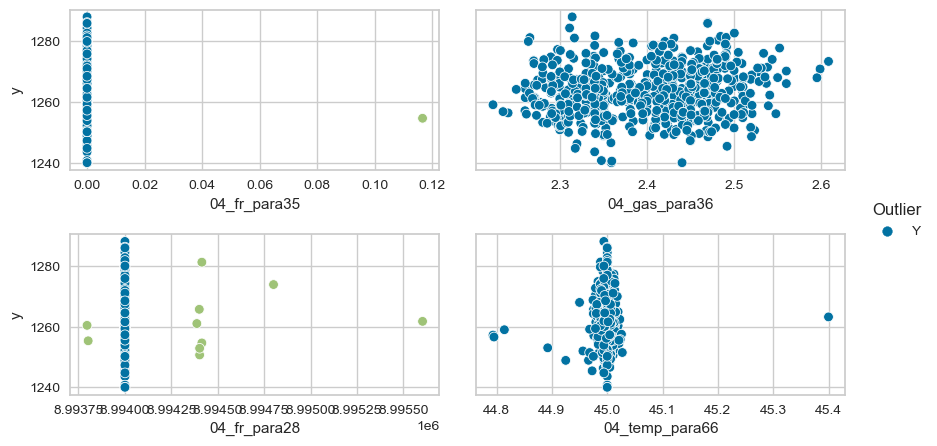

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(10,5))
fig.subplots_adjust(hspace=.4, wspace=.1)

sns.scatterplot(x='04_fr_para35', y='y', hue='04_fr_para35_outlier', data = df_outlier, ax=axes[0,0], legend=False)
sns.scatterplot(x='04_gas_para36', y='y', hue='04_gas_para36_outlier', data = df_outlier, ax=axes[0,1])
sns.scatterplot(x='04_fr_para28', y='y',  hue='04_fr_para28_outlier', data = df_outlier, ax=axes[1,0], legend=False)
sns.scatterplot(x='04_temp_para66', y='y', hue='04_temp_para66_outlier', data = df_outlier, ax=axes[1,1], legend=False)
axes[0,1].legend(loc='lower left', ncol=1, title='Outlier', bbox_to_anchor=(1.04, -0.5))

In [45]:
# 기존 센서 변수(665개)와 생성 변수 중 수치형 변수(102개) 컬럼을 정의합니다. 
col_numerical = col_sensor + df_prep_train.filter(regex='^gen_').columns.tolist()

In [46]:
def cliping(df,columns):
    
    for col in columns:

        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)

        iqr = q3 - q1

        low_lim = q3 + 1.5 * iqr
        high_lim = q1 - 1.5 * iqr

        df[col] = df[col].clip(low_lim, high_lim)

    return df

df_prep_train = cliping(df_prep_train, col_numerical)
df_prep_predict = cliping(df_prep_predict, col_numerical)

이상치 처리후 결과를 확인합니다.

<AxesSubplot: xlabel='04_temp_para66', ylabel='y'>

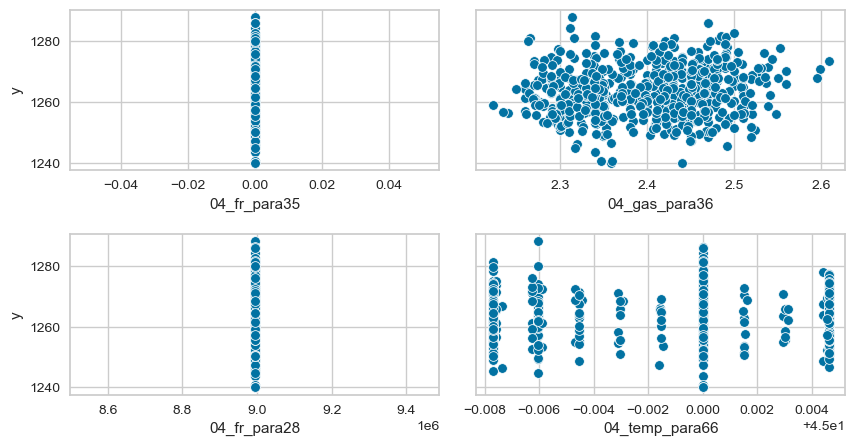

In [47]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(10,5))
fig.subplots_adjust(hspace=.4, wspace=.1)

sns.scatterplot(x='04_fr_para35', y='y', data = df_prep_train, ax=axes[0,0])
sns.scatterplot(x='04_gas_para36', y='y', data = df_prep_train, ax=axes[0,1])
sns.scatterplot(x='04_fr_para28', y='y',  data = df_prep_train, ax=axes[1,0])
sns.scatterplot(x='04_temp_para66', y='y', data = df_prep_train, ax=axes[1,1])

<a name='04-03'></a>
### 4.3 분산이 적은 변수 제거
분산 기준 설정(Variance Thresholding)은 가장 기본적인 특성 선택 방법 중 하나입니다. 

분산이 0 인 특징은 정보가 없으므로 해당 특징을 삭제합니다.

In [48]:
# threshold 인자를 변경하여 분산의 기준값을 수동으로 선택할 수 있습니다.
thresholder = VarianceThreshold(threshold=0)
_ = thresholder.fit_transform(df_prep_train[col_numerical])

 # 분산이 0이면 True 이므로 제거할 컬럼을 추출합니다.  
mask = ~thresholder.get_support()
cols_var_drop = np.asarray(col_numerical)[mask].tolist()
print(f'** {len(cols_var_drop)} Features to Drop by Low Variance')
print(f'{cols_var_drop}')

** 218 Features to Drop by Low Variance
['04_epd_para4', '04_epd_para40', '04_epd_para63', '04_epd_para80', '04_esc_para84', '04_fr_para28', '04_fr_para35', '04_fr_para69', '04_gas_para10', '04_gas_para13', '04_gas_para19', '04_gas_para27', '04_gas_para39', '04_gas_para46', '04_gas_para48', '04_gas_para50', '04_gas_para70', '04_gas_para71', '04_gas_para74', '04_he_para1', '04_he_para95', '04_power_para14', '04_power_para49', '04_power_para57', '04_power_para68', '04_power_para82', '04_temp_para24', '04_time_para5', '06_epd_para4', '06_epd_para63', '06_epd_para80', '06_esc_para84', '06_fr_para28', '06_fr_para35', '06_fr_para69', '06_gas_para10', '06_gas_para13', '06_gas_para15', '06_gas_para19', '06_gas_para27', '06_gas_para39', '06_gas_para46', '06_gas_para48', '06_gas_para50', '06_gas_para51', '06_gas_para70', '06_gas_para74', '06_gas_para85', '06_he_para1', '06_he_para95', '06_hv_para3', '06_hv_para45', '06_hv_para47', '06_hv_para56', '06_power_para14', '06_power_para68', '06_power_p

분산이 0인 특징에 대해 확인해보겠습니다.

<AxesSubplot: xlabel='04_epd_para4', ylabel='y'>

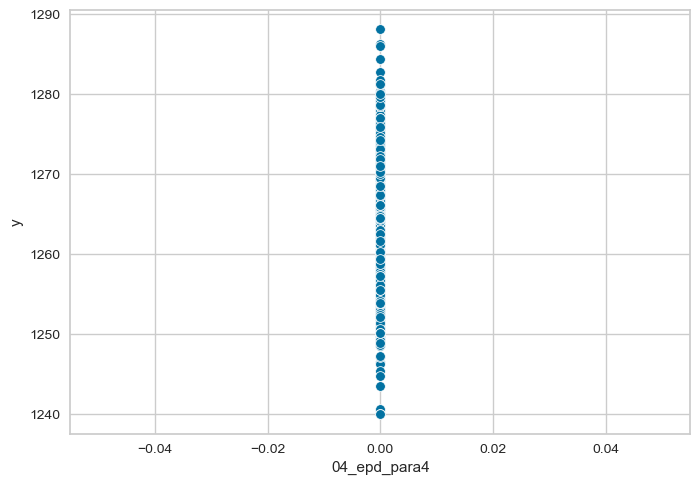

In [49]:
sns.scatterplot(x=cols_var_drop[0], y='y', data=df_prep_train)

<a name='04-05'></a>
### 4.5 원-핫 인코딩

**module_name_eq** 는 문자열로 나타난 범주형 변수입니다.

범주형 변수의 대표적인 변환 기법인 원-핫 인코딩을 사용하여 변환합니다. 

In [50]:
col_cut = df_prep_train.filter(regex = '^cut').columns.tolist()

In [51]:
def prep_cate_feats(df_tr, df_te, feat_nm):

    df_merge = pd.concat([df_tr, df_te])

    # 컬럼명과 범주형 변수의 레벨명을 이용한 새로운 컬럼명을 자동생성합니다. 
    # ex. module_name_eq -> module_name_eq_EQ01, module_name_eq_EQ02, etc.
    df_merge = pd.get_dummies(df_merge, columns=[feat_nm])

    df_tr = df_merge.iloc[:df_tr.shape[0], :].reset_index(drop=True)
    df_te = df_merge.iloc[df_tr.shape[0]:, :].reset_index(drop=True)

    return df_tr, df_te

# module_name_eq 의 원-핫 인코딩 변수를 생성합니다.
df_prep_train, df_prep_predict = prep_cate_feats(df_prep_train, df_prep_predict, 'module_name_eq')

for col in col_cut:
    df_prep_train, df_prep_predict = prep_cate_feats(df_prep_train, df_prep_predict, col)

In [52]:
df_prep_train, df_prep_predict = prep_cate_feats(df_prep_train, df_prep_predict, 'tmdiff_speed')

### 다중공선성(VIF)

In [53]:
df_prep_train.dropna(axis=1, inplace=True)
df_prep_predict.dropna(axis=1, inplace=True)

In [54]:
## 다중공선성 VIF 확인
# VIF 출력을 위한 데이터 프레임 형성
vif = pd.DataFrame()
idx_numerical = [col for col in df_prep_train.columns if (df_prep_train[col].dtype == 'float') & ('y' not in col)]

# VIF 값과 각 Feature 이름에 대해 설정
vif["VIF Factor"] = [variance_inflation_factor(df_prep_train[idx_numerical].values, i) for i in range(df_prep_train[idx_numerical].shape[1])]
vif["features"] = df_prep_train[idx_numerical].columns

# VIF 값이 높은 순으로 정렬
vif = vif.sort_values(by="VIF Factor", ascending=False)
vif = vif.reset_index().drop(columns='index')
vif  #약 10분소요 

,VIF Factor,features
0,9.340661e+11,17_time_para7
1,3.595258e+11,04_time_para37
2,2.932508e+11,gen_epd_para40_mean
3,1.883051e+11,06_time_para89
4,1.124480e+11,18_time_para34
...,...,...
871,NaN,gen_epd_para63_mean
872,NaN,gen_epd_para80_mean
873,NaN,gen_gas_para10_mean
874,NaN,gen_gas_para19_mean


In [55]:
vif_10 = vif[vif['VIF Factor'] > 10]
print(len(vif_10))
print(len([fea for fea in vif_10['features'] if ('mean' not in fea) & ('std' not in fea) & ('avg' not in fea) & ('time' not in fea)&('log_y' not in fea)]))

vif_10_lst = [fea for fea in vif_10['features'] if ('mean' not in fea) & ('std' not in fea) & ('avg' not in fea) & ('time' not in fea)&('log_y' not in fea)]

582
287


In [56]:
# PCA 처리
pca = PCA(n_components=len(vif_10_lst))

x_train_pca = pca.fit(df_prep_train[vif_10_lst])
x_predict_pca = pca.transform(df_prep_predict[vif_10_lst])

pca_result = pd.DataFrame({'설명 가능한 분산 비율':pca.explained_variance_, '기여율' : pca.explained_variance_ratio_})

In [57]:
pca_result['누적기여율'] = pca_result['기여율'].cumsum()
# 누적 기여율이 80%가 넘어가는 지점까지 적용

<AxesSubplot: ylabel='설명 가능한 분산 비율'>

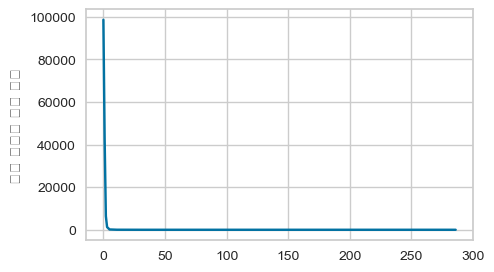

In [58]:
plt.figure(figsize = (5, 3))
sns.lineplot(x = pca_result.index, y = '설명 가능한 분산 비율', data = pca_result)
# 보통 완만해지는 부분까지 PCA 개수 선정

In [59]:
pca = PCA(n_components=2)

x_train_pca = pca.fit_transform(df_prep_train[vif_10_lst])
x_predict_pca = pca.transform(df_prep_predict[vif_10_lst])

In [60]:
pca_train = pd.DataFrame(x_train_pca, columns = [f'pca_{col}' for col in vif_10_lst[:2]])
pca_predict = pd.DataFrame(x_predict_pca, columns = [f'pca_{col}' for col in vif_10_lst[:2]])

In [61]:
df_prep_train = pd.concat([df_prep_train, pca_train], axis = 1)
df_prep_predict = pd.concat([df_prep_predict, pca_predict], axis = 1)

In [62]:
df_prep_train.drop(vif_10_lst, axis = 1, inplace = True)
df_prep_predict.drop(vif_10_lst, axis =1 , inplace = True)

<a name='04-06'></a>
### 4.6 변수 선택 

변수 선택은 주어진 데이터의 변수 중에서 모델링의 가장 적절한 변수만 선택하는 과정입니다. 

변수 선택 방법은 필터 방법(Filter method), 래퍼 방법(Wrapper method), 임베디드 방법(Embeded method)이 있습니다. 

- **필터 방법** : 통계량(ex. 상관계수, 카이제곱, 상호정보량)을 구하여 가장 뛰어난 특성을 선택하는 기법 (ex. SelectKBest)
- **래퍼 방법** : 시행착오를 통해 가장 높은 품질의 예측을 만드는 특성의 부분조합을 찾는 기법 (ex. RFE, RFECV)
- **임베디드 방법** : 결정트리 모델로부터 생성된 특징 중요도를 이용하여 특성을 선택하는 기법 (ex. SelectFromModel)

다음은 필터 방법중 상호정보량을 사용하여 중요 특성을 추출하는 예제코드입니다.

참가자들은 자유롭게 분석하며, 변수 선택 중 한가지 방법으로 참고할 수 있습니다.

In [63]:
col_numerical = col_sensor + df_prep_train.filter(regex='^gen_').columns.tolist()

In [64]:
col_numeric =  set([k for k in df_prep_train.columns if (df_prep_train[k].dtype == 'float') & ('y' not in k)] + df_prep_train.filter(regex='^gen_').columns.tolist())

In [65]:
len(col_numeric)

591

In [66]:
skb = SelectKBest(score_func=mutual_info_regression, k=250) 
skb.fit(df_prep_train[col_numeric], df_prep_train['y'])
select_features_kbest = skb.get_support()
col_featsIDX = pd.Index(df_prep_train[col_numeric].columns.tolist())
col_selected_mutual = col_featsIDX[select_features_kbest]

<a name='05'></a>
## 5. 모델링

<a name='05-01'></a>
### 5.1 데이터 분할

모델의 일반화 성능을 평가하기 위해 학습 데이터 중 일부를 검증용 데이터로 분할합니다. 

train_test_split 함수를 이용하여 학습용 데이터 중 10% 데이터를 검증 데이터로 분류합니다.

In [67]:
# 학습에 사용할 수치형 변수 컬럼을 정의합니다. 
# 앞서 정의한 col_numerical 에서 분산이 0 인 컬럼을 제거합니다.
col_numerical = [col for col in col_selected_mutual if col not in cols_var_drop]
# 학습에 사용할 원-핫 인코딩된 범주형 변수 컬럼을 정의합니다. 
col_cate_module_name_eq = df_prep_train.filter(regex='module_name_eq').columns.tolist()
col_cut_ohe = df_prep_train.filter(regex = '^cut').columns.tolist()
# 모델에 입력으로 사용될 최종 컬럼을 정의합니다.
col_X = col_numerical + col_cate_module_name_eq + col_cut_ohe
col_y = 'y'

# 학습용 데이터를 정의합니다.
x_train_raw = df_prep_train[col_X]
y_train_raw = df_prep_train[col_y]
# 평가용 데이터를 정의합니다.
x_predict = df_prep_predict[col_X]
# 학습 데이터 중 일부를 검증 데이터 셋으로 분할합니다.
x_train,x_test,y_train,y_test = train_test_split(x_train_raw, y_train_raw, test_size=0.2,random_state=1)
x_train_,x_valid,y_train_,y_valid = train_test_split(x_train, y_train, test_size=0.2,random_state=1)

print(x_train.shape,y_train.shape)
print(x_train_.shape,y_train_.shape)
print(x_valid.shape,y_valid.shape)
print(x_test.shape,y_test.shape)

(488, 417) (488,)
(390, 417) (390,)
(98, 417) (98,)
(123, 417) (123,)


In [68]:
# # 할지말지 고민을 좀 해야될듯 

# scaler = StandardScaler()
# x_train[col_numerical] = scaler.fit_transform(x_train[col_numerical])
# x_test[col_numerical] = scaler.transform(x_test[col_numerical])

#### 데이터 증강

In [69]:
os_df = x_train_.join(y_train_, how='left')

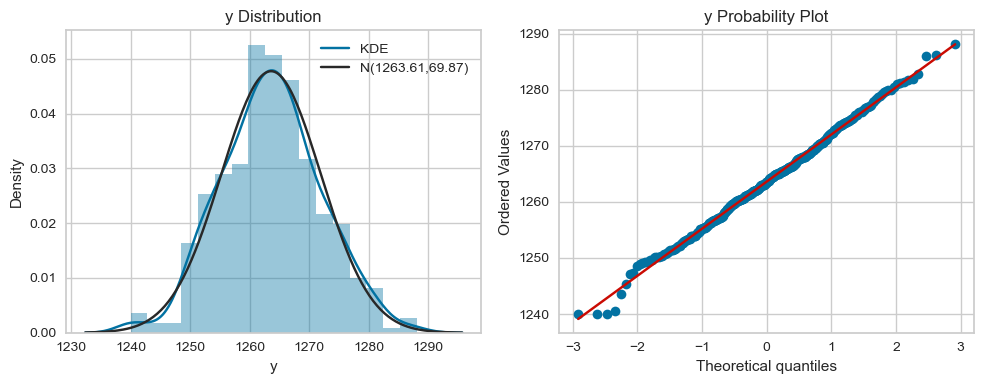

In [70]:
QQ_plot(os_df['y'], 'y')

In [71]:
len(os_df[os_df['y'] > 1283])

3

In [72]:
# mean_squared_error 의 매개변수 squared 가 False 이면 RMSE 를 반환합니다.
def rmse(y_true,y_pred):

    return round(mean_squared_error(y_true, y_pred,squared=False),4)

In [73]:
os_df.loc[os_df['y'] < 1242, 'y_cate'] = 'A'
os_df.loc[(os_df['y'] >= 1242)&(os_df['y'] <= 1283), 'y_cate'] = 'B'
os_df.loc[os_df['y'] > 1283, 'y_cate'] = 'C'

In [74]:
os_df['log_y'] = np.log1p(os_df['y']) 
y_test = np.log1p(y_test)
y_valid = np.log1p(y_valid)
os_df.drop('y',axis=1,inplace=True)

In [75]:
os_df, os_target = RandomOverSampler(random_state=1).fit_resample(os_df.drop('y_cate',axis=1), os_df['y_cate'])

# AUTO ML

데이터 자동 전처리 및 파이프라인 생성

In [116]:
#전처리
# ata = input data, target = target data,
# session_id = int (seed 정하기), normalize = 정규화 할지, 
# transfomation = 데이터를 정규화분포에 가깝게
# log_y or y 
reg_test_1 = setup(data=os_df,
                   target= 'log_y',
                   normalize=True, 
                   train_size= 0.6,
                   #fold=5,
                   session_id=123)

,Description,Value
0,session_id,123
1,Target,log_y
2,Original Data,"(1149, 418)"
3,Missing Values,False
4,Numeric Features,417
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(689, 156)"


알고리즘 자동 비교  


compare_models는 머신러닝의 여러 알고리즘을 자동으로 생성하여 비교해줍니다.   
sort는 알고리즘들의 정렬 순서를 의미하며, n_select옵션을 설정하지 않으면 mse성능이 가장 좋은 알고리즘의 파라미터들이 best에 저장됩니다.  

setup에서 kfold 옵션을 설정했기 때문에 Kfold 교차검증의 결과값이 표시됩니다.

In [117]:
#알고리즘 비교 
best = compare_models(sort='RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.0015,0.0000,0.0034,0.9486,0.0004,0.0002,0.0900
catboost,CatBoost Regressor,0.0016,0.0000,0.0034,0.9479,0.0004,0.0002,1.6920
et,Extra Trees Regressor,0.0016,0.0000,0.0035,0.9469,0.0004,0.0002,0.0660
lightgbm,Light Gradient Boosting Machine,0.0016,0.0000,0.0037,0.9404,0.0005,0.0002,0.0200
gbr,Gradient Boosting Regressor,0.0017,0.0000,0.0037,0.9389,0.0005,0.0002,0.0660
xgboost,Extreme Gradient Boosting,0.0019,0.0000,0.0042,0.9237,0.0005,0.0003,0.0390
knn,K Neighbors Regressor,0.0019,0.0000,0.0043,0.9135,0.0005,0.0003,0.0050
dt,Decision Tree Regressor,0.0021,0.0000,0.0046,0.9049,0.0006,0.0003,0.0060
ada,AdaBoost Regressor,0.0039,0.0000,0.0046,0.9096,0.0006,0.0006,0.0350
omp,Orthogonal Matching Pursuit,0.0029,0.0000,0.0053,0.8780,0.0006,0.0004,0.0040


모델 튜닝  



In [118]:
#모델 튜닝  
best_tune = tune_model(best)
best_tune

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0012,0.0000,0.0027,0.9723,0.0003,0.0002
1,0.0024,0.0000,0.0043,0.9172,0.0005,0.0003
2,0.0017,0.0000,0.0035,0.9532,0.0004,0.0002
3,0.0022,0.0000,0.0041,0.9272,0.0005,0.0003
4,0.0017,0.0000,0.0033,0.9548,0.0004,0.0002
5,0.0019,0.0000,0.0038,0.9402,0.0005,0.0003
6,0.0019,0.0000,0.0033,0.9520,0.0004,0.0003
7,0.0017,0.0000,0.0035,0.9507,0.0004,0.0002
8,0.0011,0.0000,0.0027,0.9721,0.0003,0.0002


RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mae',
                      max_depth=4, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0002,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=9, min_weight_fraction_leaf=0.0,
                      n_estimators=130, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)

In [119]:
cat = create_model('catboost', cross_validation = True)
et = create_model('et', cross_validation = True)
rf = create_model('rf', cross_validation = True)
gbr = create_model('gbr', cross_validation = True)
lightgbm = create_model('lightgbm',cross_validation=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0011,0.0000,0.0029,0.9682,0.0004,0.0001
1,0.0021,0.0000,0.0046,0.9057,0.0006,0.0003
2,0.0017,0.0000,0.0039,0.9421,0.0005,0.0002
3,0.0021,0.0000,0.0040,0.9299,0.0005,0.0003
4,0.0013,0.0000,0.0028,0.9672,0.0003,0.0002
5,0.0020,0.0000,0.0050,0.8983,0.0006,0.0003
6,0.0018,0.0000,0.0038,0.9380,0.0005,0.0002
7,0.0017,0.0000,0.0036,0.9473,0.0004,0.0002
8,0.0009,0.0000,0.0020,0.9836,0.0003,0.0001


In [120]:
#정보시각화
evaluate_model(best_tune)  #extra regresstion

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

- 튜닝튜닝

In [121]:
# 팬돌아감;   # n_iter = 10 20
tuned_cat = tune_model(cat, optimize = 'RMSE', n_iter = 20)
tuned_et = tune_model(et, optimize = 'RMSE', n_iter = 20)
tuned_rf = tune_model(rf, optimize = 'RMSE', n_iter = 20)
tuned_gbr = tune_model(gbr, optimize = 'RMSE', n_iter = 20)
tuned_lightgbm = tune_model(lightgbm, optimize = 'RMSE', n_iter = 20)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0152,0.0003,0.0163,0.0141,0.0020,0.0021
1,0.0136,0.0002,0.0152,-0.0335,0.0019,0.0019
2,0.0151,0.0003,0.0161,-0.0071,0.0020,0.0021
3,0.0135,0.0002,0.0150,0.0135,0.0018,0.0019
4,0.0143,0.0002,0.0158,-0.0121,0.0019,0.0020
5,0.0143,0.0002,0.0156,0.0030,0.0019,0.0020
6,0.0137,0.0002,0.0153,-0.0319,0.0019,0.0019
7,0.0140,0.0002,0.0155,0.0050,0.0019,0.0020
8,0.0144,0.0003,0.0159,0.0162,0.0020,0.0020


In [122]:
#예측값 보기 
predict_model(tuned_cat)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.0018,0.0000,0.0037,0.9401,0.0005,0.0003


,13_gas_para13,20_temp_para92,gen_tmp_para31_std,12_power_para82,gen_gas_para74_std,gen_temp_para23_std,gen_temp_para86_mean,gen_pressure_para91_mean,gen_temp_para53_mean,18_power_para82,...,cut_18_gas_para19_g,cut_20_hv_para3_a,cut_20_hv_para3_b,cut_20_hv_para3_c,cut_20_hv_para3_d,cut_17_fr_para35_B,cut_20_fr_para35_A,cut_20_fr_para35_B,log_y,Label
0,-0.598439,-0.338299,0.906291,-0.279787,-0.702442,-0.046557,1.571524,2.328547,-0.698396,-0.081925,...,0,0,1,0,0,0,1,0,7.134670,7.141804
1,-0.598439,1.827215,0.693529,-0.175281,-0.525496,-0.745234,0.526333,0.575061,0.660191,-0.081925,...,0,0,1,0,0,0,1,0,7.123673,7.123680
2,-0.598439,1.827215,0.693529,-0.175281,-0.525496,-0.745234,0.526333,0.575061,0.660191,-0.081925,...,0,0,1,0,0,0,1,0,7.123673,7.123680
3,-0.398085,-0.883278,-0.054470,0.367642,-0.525496,0.574143,-0.276660,-0.681918,1.592073,-0.081925,...,0,0,1,0,0,0,1,0,7.160055,7.160049
4,-0.398085,-0.883278,-0.054470,0.367642,-0.525496,0.574143,-0.276660,-0.681918,1.592073,-0.081925,...,0,0,1,0,0,0,1,0,7.160055,7.160049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,-0.398085,-0.439975,-1.789330,0.319213,-0.525496,-0.918197,0.153801,-0.185412,-0.483817,0.983060,...,0,0,0,1,0,0,1,0,7.124094,7.124105
456,-0.598439,-0.644843,-0.673732,0.319213,-0.525496,0.827721,-0.135013,-0.551731,-1.446354,0.184911,...,0,0,1,0,0,0,1,0,7.160258,7.160248
457,1.850326,-0.441600,-0.757431,0.031183,1.862069,1.159695,-1.837865,2.956139,-2.705621,0.184911,...,1,0,1,0,0,0,1,0,7.156258,7.143846
458,-0.598439,-0.856641,0.838099,-2.889897,-0.586350,1.503998,-0.714080,-3.438295,0.174631,-3.031297,...,0,0,1,0,0,0,1,0,7.134790,7.140999


In [123]:
#예측값 보기 
predict_model(tuned_et)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0025,0.0000,0.0045,0.9108,0.0006,0.0003


,13_gas_para13,20_temp_para92,gen_tmp_para31_std,12_power_para82,gen_gas_para74_std,gen_temp_para23_std,gen_temp_para86_mean,gen_pressure_para91_mean,gen_temp_para53_mean,18_power_para82,...,cut_18_gas_para19_g,cut_20_hv_para3_a,cut_20_hv_para3_b,cut_20_hv_para3_c,cut_20_hv_para3_d,cut_17_fr_para35_B,cut_20_fr_para35_A,cut_20_fr_para35_B,log_y,Label
0,-0.598439,-0.338299,0.906291,-0.279787,-0.702442,-0.046557,1.571524,2.328547,-0.698396,-0.081925,...,0,0,1,0,0,0,1,0,7.134670,7.141925
1,-0.598439,1.827215,0.693529,-0.175281,-0.525496,-0.745234,0.526333,0.575061,0.660191,-0.081925,...,0,0,1,0,0,0,1,0,7.123673,7.123729
2,-0.598439,1.827215,0.693529,-0.175281,-0.525496,-0.745234,0.526333,0.575061,0.660191,-0.081925,...,0,0,1,0,0,0,1,0,7.123673,7.123729
3,-0.398085,-0.883278,-0.054470,0.367642,-0.525496,0.574143,-0.276660,-0.681918,1.592073,-0.081925,...,0,0,1,0,0,0,1,0,7.160055,7.160203
4,-0.398085,-0.883278,-0.054470,0.367642,-0.525496,0.574143,-0.276660,-0.681918,1.592073,-0.081925,...,0,0,1,0,0,0,1,0,7.160055,7.160203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,-0.398085,-0.439975,-1.789330,0.319213,-0.525496,-0.918197,0.153801,-0.185412,-0.483817,0.983060,...,0,0,0,1,0,0,1,0,7.124094,7.123673
456,-0.598439,-0.644843,-0.673732,0.319213,-0.525496,0.827721,-0.135013,-0.551731,-1.446354,0.184911,...,0,0,1,0,0,0,1,0,7.160258,7.160111
457,1.850326,-0.441600,-0.757431,0.031183,1.862069,1.159695,-1.837865,2.956139,-2.705621,0.184911,...,1,0,1,0,0,0,1,0,7.156258,7.146692
458,-0.598439,-0.856641,0.838099,-2.889897,-0.586350,1.503998,-0.714080,-3.438295,0.174631,-3.031297,...,0,0,1,0,0,0,1,0,7.134790,7.147230


In [124]:
#예측값 보기 
predict_model(tuned_rf) 

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0021,0.0000,0.0038,0.9386,0.0005,0.0003


,13_gas_para13,20_temp_para92,gen_tmp_para31_std,12_power_para82,gen_gas_para74_std,gen_temp_para23_std,gen_temp_para86_mean,gen_pressure_para91_mean,gen_temp_para53_mean,18_power_para82,...,cut_18_gas_para19_g,cut_20_hv_para3_a,cut_20_hv_para3_b,cut_20_hv_para3_c,cut_20_hv_para3_d,cut_17_fr_para35_B,cut_20_fr_para35_A,cut_20_fr_para35_B,log_y,Label
0,-0.598439,-0.338299,0.906291,-0.279787,-0.702442,-0.046557,1.571524,2.328547,-0.698396,-0.081925,...,0,0,1,0,0,0,1,0,7.134670,7.142233
1,-0.598439,1.827215,0.693529,-0.175281,-0.525496,-0.745234,0.526333,0.575061,0.660191,-0.081925,...,0,0,1,0,0,0,1,0,7.123673,7.123673
2,-0.598439,1.827215,0.693529,-0.175281,-0.525496,-0.745234,0.526333,0.575061,0.660191,-0.081925,...,0,0,1,0,0,0,1,0,7.123673,7.123673
3,-0.398085,-0.883278,-0.054470,0.367642,-0.525496,0.574143,-0.276660,-0.681918,1.592073,-0.081925,...,0,0,1,0,0,0,1,0,7.160055,7.160200
4,-0.398085,-0.883278,-0.054470,0.367642,-0.525496,0.574143,-0.276660,-0.681918,1.592073,-0.081925,...,0,0,1,0,0,0,1,0,7.160055,7.160200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,-0.398085,-0.439975,-1.789330,0.319213,-0.525496,-0.918197,0.153801,-0.185412,-0.483817,0.983060,...,0,0,0,1,0,0,1,0,7.124094,7.123718
456,-0.598439,-0.644843,-0.673732,0.319213,-0.525496,0.827721,-0.135013,-0.551731,-1.446354,0.184911,...,0,0,1,0,0,0,1,0,7.160258,7.160235
457,1.850326,-0.441600,-0.757431,0.031183,1.862069,1.159695,-1.837865,2.956139,-2.705621,0.184911,...,1,0,1,0,0,0,1,0,7.156258,7.143183
458,-0.598439,-0.856641,0.838099,-2.889897,-0.586350,1.503998,-0.714080,-3.438295,0.174631,-3.031297,...,0,0,1,0,0,0,1,0,7.134790,7.142210


In [125]:
#예측값 보기 
predict_model(tuned_gbr)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.0026,0.0000,0.0042,0.9218,0.0005,0.0004


,13_gas_para13,20_temp_para92,gen_tmp_para31_std,12_power_para82,gen_gas_para74_std,gen_temp_para23_std,gen_temp_para86_mean,gen_pressure_para91_mean,gen_temp_para53_mean,18_power_para82,...,cut_18_gas_para19_g,cut_20_hv_para3_a,cut_20_hv_para3_b,cut_20_hv_para3_c,cut_20_hv_para3_d,cut_17_fr_para35_B,cut_20_fr_para35_A,cut_20_fr_para35_B,log_y,Label
0,-0.598439,-0.338299,0.906291,-0.279787,-0.702442,-0.046557,1.571524,2.328547,-0.698396,-0.081925,...,0,0,1,0,0,0,1,0,7.134670,7.141738
1,-0.598439,1.827215,0.693529,-0.175281,-0.525496,-0.745234,0.526333,0.575061,0.660191,-0.081925,...,0,0,1,0,0,0,1,0,7.123673,7.124683
2,-0.598439,1.827215,0.693529,-0.175281,-0.525496,-0.745234,0.526333,0.575061,0.660191,-0.081925,...,0,0,1,0,0,0,1,0,7.123673,7.124683
3,-0.398085,-0.883278,-0.054470,0.367642,-0.525496,0.574143,-0.276660,-0.681918,1.592073,-0.081925,...,0,0,1,0,0,0,1,0,7.160055,7.159453
4,-0.398085,-0.883278,-0.054470,0.367642,-0.525496,0.574143,-0.276660,-0.681918,1.592073,-0.081925,...,0,0,1,0,0,0,1,0,7.160055,7.159453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,-0.398085,-0.439975,-1.789330,0.319213,-0.525496,-0.918197,0.153801,-0.185412,-0.483817,0.983060,...,0,0,0,1,0,0,1,0,7.124094,7.124683
456,-0.598439,-0.644843,-0.673732,0.319213,-0.525496,0.827721,-0.135013,-0.551731,-1.446354,0.184911,...,0,0,1,0,0,0,1,0,7.160258,7.159453
457,1.850326,-0.441600,-0.757431,0.031183,1.862069,1.159695,-1.837865,2.956139,-2.705621,0.184911,...,1,0,1,0,0,0,1,0,7.156258,7.141433
458,-0.598439,-0.856641,0.838099,-2.889897,-0.586350,1.503998,-0.714080,-3.438295,0.174631,-3.031297,...,0,0,1,0,0,0,1,0,7.134790,7.145315


In [126]:
#예측값 보기 
predict_model(tuned_lightgbm)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0134,0.0002,0.0150,0.0182,0.0018,0.0019


,13_gas_para13,20_temp_para92,gen_tmp_para31_std,12_power_para82,gen_gas_para74_std,gen_temp_para23_std,gen_temp_para86_mean,gen_pressure_para91_mean,gen_temp_para53_mean,18_power_para82,...,cut_18_gas_para19_g,cut_20_hv_para3_a,cut_20_hv_para3_b,cut_20_hv_para3_c,cut_20_hv_para3_d,cut_17_fr_para35_B,cut_20_fr_para35_A,cut_20_fr_para35_B,log_y,Label
0,-0.598439,-0.338299,0.906291,-0.279787,-0.702442,-0.046557,1.571524,2.328547,-0.698396,-0.081925,...,0,0,1,0,0,0,1,0,7.134670,7.142305
1,-0.598439,1.827215,0.693529,-0.175281,-0.525496,-0.745234,0.526333,0.575061,0.660191,-0.081925,...,0,0,1,0,0,0,1,0,7.123673,7.141926
2,-0.598439,1.827215,0.693529,-0.175281,-0.525496,-0.745234,0.526333,0.575061,0.660191,-0.081925,...,0,0,1,0,0,0,1,0,7.123673,7.141926
3,-0.398085,-0.883278,-0.054470,0.367642,-0.525496,0.574143,-0.276660,-0.681918,1.592073,-0.081925,...,0,0,1,0,0,0,1,0,7.160055,7.142305
4,-0.398085,-0.883278,-0.054470,0.367642,-0.525496,0.574143,-0.276660,-0.681918,1.592073,-0.081925,...,0,0,1,0,0,0,1,0,7.160055,7.142305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,-0.398085,-0.439975,-1.789330,0.319213,-0.525496,-0.918197,0.153801,-0.185412,-0.483817,0.983060,...,0,0,0,1,0,0,1,0,7.124094,7.141926
456,-0.598439,-0.644843,-0.673732,0.319213,-0.525496,0.827721,-0.135013,-0.551731,-1.446354,0.184911,...,0,0,1,0,0,0,1,0,7.160258,7.142305
457,1.850326,-0.441600,-0.757431,0.031183,1.862069,1.159695,-1.837865,2.956139,-2.705621,0.184911,...,1,0,1,0,0,0,1,0,7.156258,7.142305
458,-0.598439,-0.856641,0.838099,-2.889897,-0.586350,1.503998,-0.714080,-3.438295,0.174631,-3.031297,...,0,0,1,0,0,0,1,0,7.134790,7.142305


In [127]:
# 새로운 데이터로 예측한 결과를 보기 
predict_model(tuned_cat, data= x_test)

,17_time_para90,13_gas_para13,20_temp_para92,12_time_para16,06_time_para67,18_time_para90,gen_tmp_para31_std,12_power_para82,13_time_para43,04_time_para67,...,cut_20_gas_para19_g,cut_20_hv_para3_a,cut_20_hv_para3_b,cut_20_hv_para3_c,cut_20_hv_para3_d,cut_17_fr_para35_A,cut_17_fr_para35_B,cut_20_fr_para35_A,cut_20_fr_para35_B,Label
49,2739.88330,144.6000,34.945274,2739.6667,2739.6333,2739.88330,0.569941,14998.792,2739.6667,2739.6167,...,0,0,1,0,0,0,1,0,1,7.142679
237,1009.20000,144.6000,34.932170,3824.0830,3824.0330,1009.20000,0.542219,15000.730,3824.0830,3824.0170,...,0,0,0,1,0,1,0,1,0,7.143746
195,1694.43300,144.6940,34.878207,1694.2170,1694.1500,1694.43300,0.525574,15000.000,1694.2170,1694.1500,...,0,1,0,0,0,0,0,0,0,7.141266
605,1210.58300,144.6940,34.990300,1210.3670,1210.3170,1210.58300,0.542491,15001.000,1210.3670,1210.3000,...,0,0,1,0,0,1,0,1,0,7.140032
197,1526.65000,144.6940,34.878207,1526.4330,1526.3830,1526.65000,0.520523,15000.020,1526.4330,1526.3830,...,0,1,0,0,0,0,0,0,0,7.141800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2757.68300,144.6000,34.935910,2757.4670,2757.4170,2757.68300,0.538307,14999.920,2757.4670,2757.4000,...,0,1,0,0,0,1,0,1,0,7.143749
40,32.88333,144.6000,34.941390,2663.5670,2663.5000,32.88333,0.513316,15000.110,2663.5670,2663.5000,...,0,0,0,1,0,1,0,1,0,7.139544
409,2326.21700,144.6000,34.928930,2326.0000,2325.9500,2326.21700,0.532449,15000.850,2326.0000,2325.9330,...,0,0,0,0,1,0,0,0,0,7.142195
173,1543.71700,144.6940,34.972640,1543.5000,1543.4330,1543.71700,0.536272,14998.830,1543.5000,1543.4330,...,0,0,0,1,0,0,0,0,0,7.141973


- blending 모델 혼합하기 

In [128]:
blender_specific = blend_models(estimator_list = [tuned_cat,tuned_et,tuned_rf,tuned_gbr,tuned_lightgbm], optimize = 'RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0040,0.0000,0.0044,0.9290,0.0005,0.0006
1,0.0048,0.0000,0.0056,0.8604,0.0007,0.0007
2,0.0044,0.0000,0.0049,0.9091,0.0006,0.0006
3,0.0044,0.0000,0.0050,0.8908,0.0006,0.0006
4,0.0043,0.0000,0.0047,0.9093,0.0006,0.0006
5,0.0045,0.0000,0.0052,0.8898,0.0006,0.0006
6,0.0041,0.0000,0.0046,0.9092,0.0006,0.0006
7,0.0041,0.0000,0.0047,0.9105,0.0006,0.0006
8,0.0037,0.0000,0.0041,0.9351,0.0005,0.0005


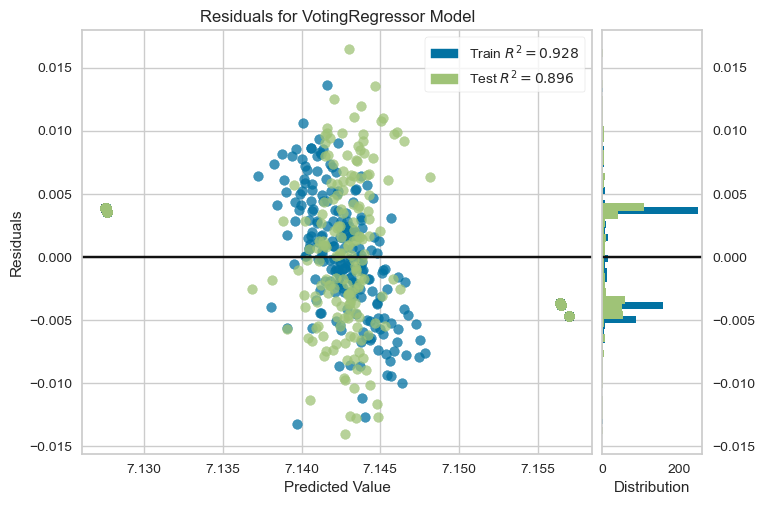

In [129]:
plot_model(blender_specific)

In [130]:
fin_model = finalize_model(blender_specific)

/Users/jinsookim/opt/anaconda3/envs/your_env/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/jinsookim/opt/anaconda3/envs/your_env/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/jinsookim/opt/anaconda3/envs/your_env/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/jinsookim/opt/anaconda3/envs/your_env/lib/pyt

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will b

/Users/jinsookim/opt/anaconda3/envs/your_env/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/jinsookim/opt/anaconda3/envs/your_env/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/jinsookim/opt/anaconda3/envs/your_env/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/jinsookim/opt/anaconda3/envs/your_env/lib/pyt

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


In [131]:
pred = predict_model(fin_model, data = x_test)

In [132]:
pred

,17_time_para90,13_gas_para13,20_temp_para92,12_time_para16,06_time_para67,18_time_para90,gen_tmp_para31_std,12_power_para82,13_time_para43,04_time_para67,...,cut_20_gas_para19_g,cut_20_hv_para3_a,cut_20_hv_para3_b,cut_20_hv_para3_c,cut_20_hv_para3_d,cut_17_fr_para35_A,cut_17_fr_para35_B,cut_20_fr_para35_A,cut_20_fr_para35_B,Label
49,2739.88330,144.6000,34.945274,2739.6667,2739.6333,2739.88330,0.569941,14998.792,2739.6667,2739.6167,...,0,0,1,0,0,0,1,0,1,7.142557
237,1009.20000,144.6000,34.932170,3824.0830,3824.0330,1009.20000,0.542219,15000.730,3824.0830,3824.0170,...,0,0,0,1,0,1,0,1,0,7.141359
195,1694.43300,144.6940,34.878207,1694.2170,1694.1500,1694.43300,0.525574,15000.000,1694.2170,1694.1500,...,0,1,0,0,0,0,0,0,0,7.142880
605,1210.58300,144.6940,34.990300,1210.3670,1210.3170,1210.58300,0.542491,15001.000,1210.3670,1210.3000,...,0,0,1,0,0,1,0,1,0,7.140500
197,1526.65000,144.6940,34.878207,1526.4330,1526.3830,1526.65000,0.520523,15000.020,1526.4330,1526.3830,...,0,1,0,0,0,0,0,0,0,7.142810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2757.68300,144.6000,34.935910,2757.4670,2757.4170,2757.68300,0.538307,14999.920,2757.4670,2757.4000,...,0,1,0,0,0,1,0,1,0,7.141615
40,32.88333,144.6000,34.941390,2663.5670,2663.5000,32.88333,0.513316,15000.110,2663.5670,2663.5000,...,0,0,0,1,0,1,0,1,0,7.136247
409,2326.21700,144.6000,34.928930,2326.0000,2325.9500,2326.21700,0.532449,15000.850,2326.0000,2325.9330,...,0,0,0,0,1,0,0,0,0,7.141393
173,1543.71700,144.6940,34.972640,1543.5000,1543.4330,1543.71700,0.536272,14998.830,1543.5000,1543.4330,...,0,0,0,1,0,0,0,0,0,7.141707


In [133]:
# rmse(y_test,pred['Label'])

In [134]:
rmse(np.expm1(y_test), np.expm1(pred['Label']))

7.5485